#### Import needed libraries

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import stumpy
from pathlib import Path
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, OPTICS
from sklearn.mixture import GaussianMixture

import warnings 
warnings.filterwarnings('ignore')

#### 1. Choose the protein

In [51]:
PROTEIN = "HNRNPC"
# PROTEIN = "HNRNPA2B1"

# Directiories to load data
PROTEIN_FOLDER = Path(f"./{PROTEIN}")
EXPECTED_PATTERN_FILE = PROTEIN_FOLDER / f"{PROTEIN.lower()}_expected_pattern.txt"
PATTERN_CANDIDATES_FOLDER = PROTEIN_FOLDER / f"{PROTEIN.lower()}_binding_sites_fshape"
PATTERN_SEARCH_FOLDER = PROTEIN_FOLDER / f"{PROTEIN.lower()}_search_fshape"

# Directory to save results (xlsx file)
DESTINATION_PATH = PROTEIN_FOLDER / f"{PROTEIN.lower()}_results.xlsx"
CLUSTER_ANALYSIS_PATH = PROTEIN_FOLDER / f"{PROTEIN.lower()}_cluster_analysis_pca.png"
MOTIFS_PATH = PROTEIN_FOLDER / f"{PROTEIN.lower()}_motifs.png"

#### 2. Check the expected pattern and its length

In [52]:
expected_pattern_df = pd.read_csv(EXPECTED_PATTERN_FILE, sep="\t", header=None, names=["fSHAPE", "base"])
expected_pattern_size = expected_pattern_df.shape[0]
print("Expected pattern size:", expected_pattern_size)
expected_pattern = ''.join(expected_pattern_df["base"])
expected_pattern_df


Expected pattern size: 6


,fSHAPE,base
0,0.00,N
1,1.25,T
2,1.15,T
3,3.00,T
4,1.70,T
5,0.10,N


#### 3. Define lengths of promising patterns

In [53]:
pattern_lengths = [expected_pattern_size, expected_pattern_size + 1, expected_pattern_size + 2]

#### 4. Extract all promising, continuous patterns of lengths w = len ... len + 2 without NaNs and with at least one nucleotide with fSHAPE > 1.0

In [54]:
def is_promising(pattern):
    if pattern.isnull().values.any():
        return False
    return (pattern > 1.0).any()

In [55]:
patterns = defaultdict(list)
fshapes = defaultdict(list)

for candidate_file in PATTERN_CANDIDATES_FOLDER.glob("*"):
    candidates_df = pd.read_csv(candidate_file, sep="\t", header=None, names=["fSHAPE", "base", "SHAPE"])
    for pattern_length in pattern_lengths:
        promising_patterns = candidates_df["fSHAPE"].rolling(pattern_length).apply(is_promising)
        # print(promising_patterns)
        for i in range(candidates_df.shape[0]):
            if promising_patterns[i] == 1:
                patterns[pattern_length].append(candidates_df["base"][i - pattern_length + 1 : i + 1].to_numpy())
                fshapes[pattern_length].append(candidates_df["fSHAPE"][i - pattern_length + 1 : i + 1].to_numpy())

print(f"Found {sum([len(x) for x in patterns.values()])} patterns")

example_pattern_length = pattern_lengths[1]
print(f'example pattern of length {example_pattern_length}:')
print(patterns[example_pattern_length][0])
print(fshapes[example_pattern_length][0])

Found 2140 patterns
example pattern of length 7:
['C' 'A' 'C' 'C' 'T' 'A' 'A']
[-0.0073148   0.6515937   0.24909604  0.12207691  0.27174267  0.59119743
  1.78560917]


#### 5. Clustering analysis with use of KMEANS++, DBSCAN, GaussianMixture

In [56]:
def plot_pca_clusters(data, labels, ax, algorithm):
    targets = np.unique(labels)
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(data)
    for target in targets:
        ax.scatter(embeddings[labels == target, 0], embeddings[labels == target, 1], s=50, alpha=0.5, edgecolors='none')

    ax.set_title(algorithm)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_xscale('log')
    print(f"Explained variance of {algorithm}: {pca.explained_variance_ratio_}")


Length Number: 6
Explained variance of KMeans: [0.85918968 0.04786084]
Explained variance of DBSCAN: [0.85918968 0.04786084]
Explained variance of GaussianMixture: [0.85918968 0.04786084]
Length Number: 7
Explained variance of KMeans: [0.9184672  0.02415631]
Explained variance of DBSCAN: [0.9184672  0.02415631]
Explained variance of GaussianMixture: [0.9184672  0.02415631]
Length Number: 8
Explained variance of KMeans: [0.86462297 0.08159485]
Explained variance of DBSCAN: [0.86462297 0.08159485]
Explained variance of GaussianMixture: [0.86462297 0.08159485]


<Figure size 640x480 with 0 Axes>

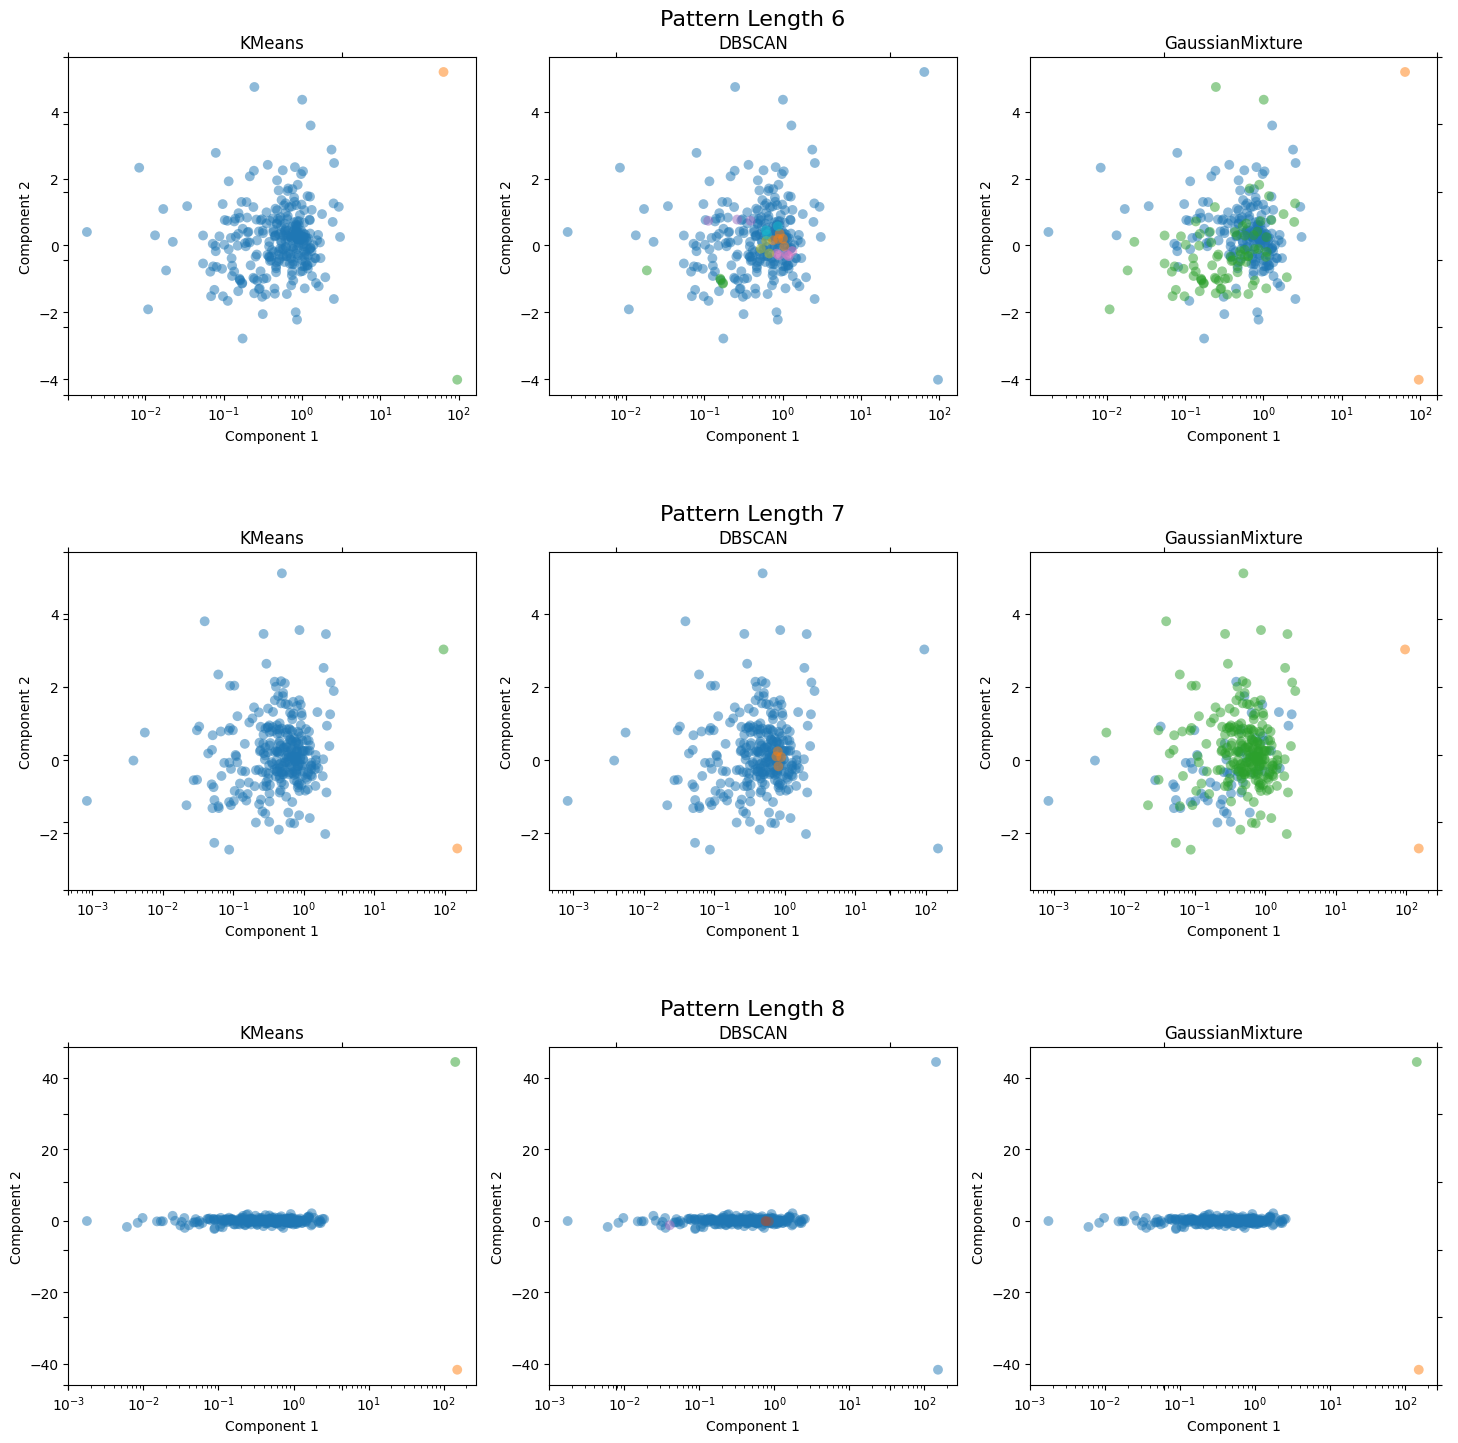

In [64]:
fig = plt.figure(constrained_layout=True)
fig.suptitle('Clustering PCA analysis')
subfigs = fig.subfigures(nrows=3, ncols=1)

fig, big_axes = plt.subplots(figsize=(15.0, 15.0), ncols=1, nrows=3, sharey=True)
for i, length in enumerate(pattern_lengths):
    print('Length Number:', length)
    curr_fshapes = fshapes[length]
    big_axes[i].set_title(f"Pattern Length {length}\n", fontsize=16)
    big_axes[i].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_axes[i]._frameon = False
    ax = fig.add_subplot(3, 3, 3*i+1)
    y_pred = KMeans(n_clusters=3).fit_predict(curr_fshapes)
    plot_pca_clusters(curr_fshapes, y_pred, ax, 'KMeans')
    ax = fig.add_subplot(3, 3, 3*i+2)
    y_pred = DBSCAN(eps=0.4, min_samples=3).fit_predict(curr_fshapes)
    # y_pred = clustering.labels_.astype(int)
    plot_pca_clusters(curr_fshapes, y_pred, ax, 'DBSCAN')
    ax = fig.add_subplot(3, 3, 3*i+3)
    y_pred = GaussianMixture(n_components=3).fit_predict(curr_fshapes)
    plot_pca_clusters(curr_fshapes, y_pred, ax, 'GaussianMixture')
plt.tight_layout()
plt.show()
# plt.savefig(CLUSTER_ANALYSIS_PATH)

#### 6. Count promising consensus motifs based on fShapes' in 3 most numerous clusters. 

In [65]:
def plot_motifs(cluster, cluster_fshapes, consensus_motif_idx, ax, color):
    for i, motif in enumerate(cluster_fshapes):
        label, lw = None, 1
        if i == consensus_motif_idx:
            label = f"Cluster {cluster} motifs"
            lw = 4
        ax.plot(stumpy.core.z_norm(motif), color=color, lw=lw, label=label)

Biggest clusters: [1 0 5]
[ 5  5 42]
Consensus motif for cluster 1: TCCACT
Consensus motif for cluster 0: CCCCAT
Consensus motif for cluster 5: CGCAGC
Biggest clusters: [1 0 2]
[ 3  4 24]
Consensus motif for cluster 1: TTGAGAC
Consensus motif for cluster 0: TCCGGTG
Consensus motif for cluster 2: AATTCTG
Biggest clusters: [2 0 1]
[ 3  3 12]
Consensus motif for cluster 2: AAACAGAC
Consensus motif for cluster 0: AATTCTGC
Consensus motif for cluster 1: TCCACTCT


Text(0.5, 0, 'Position number in pattern')

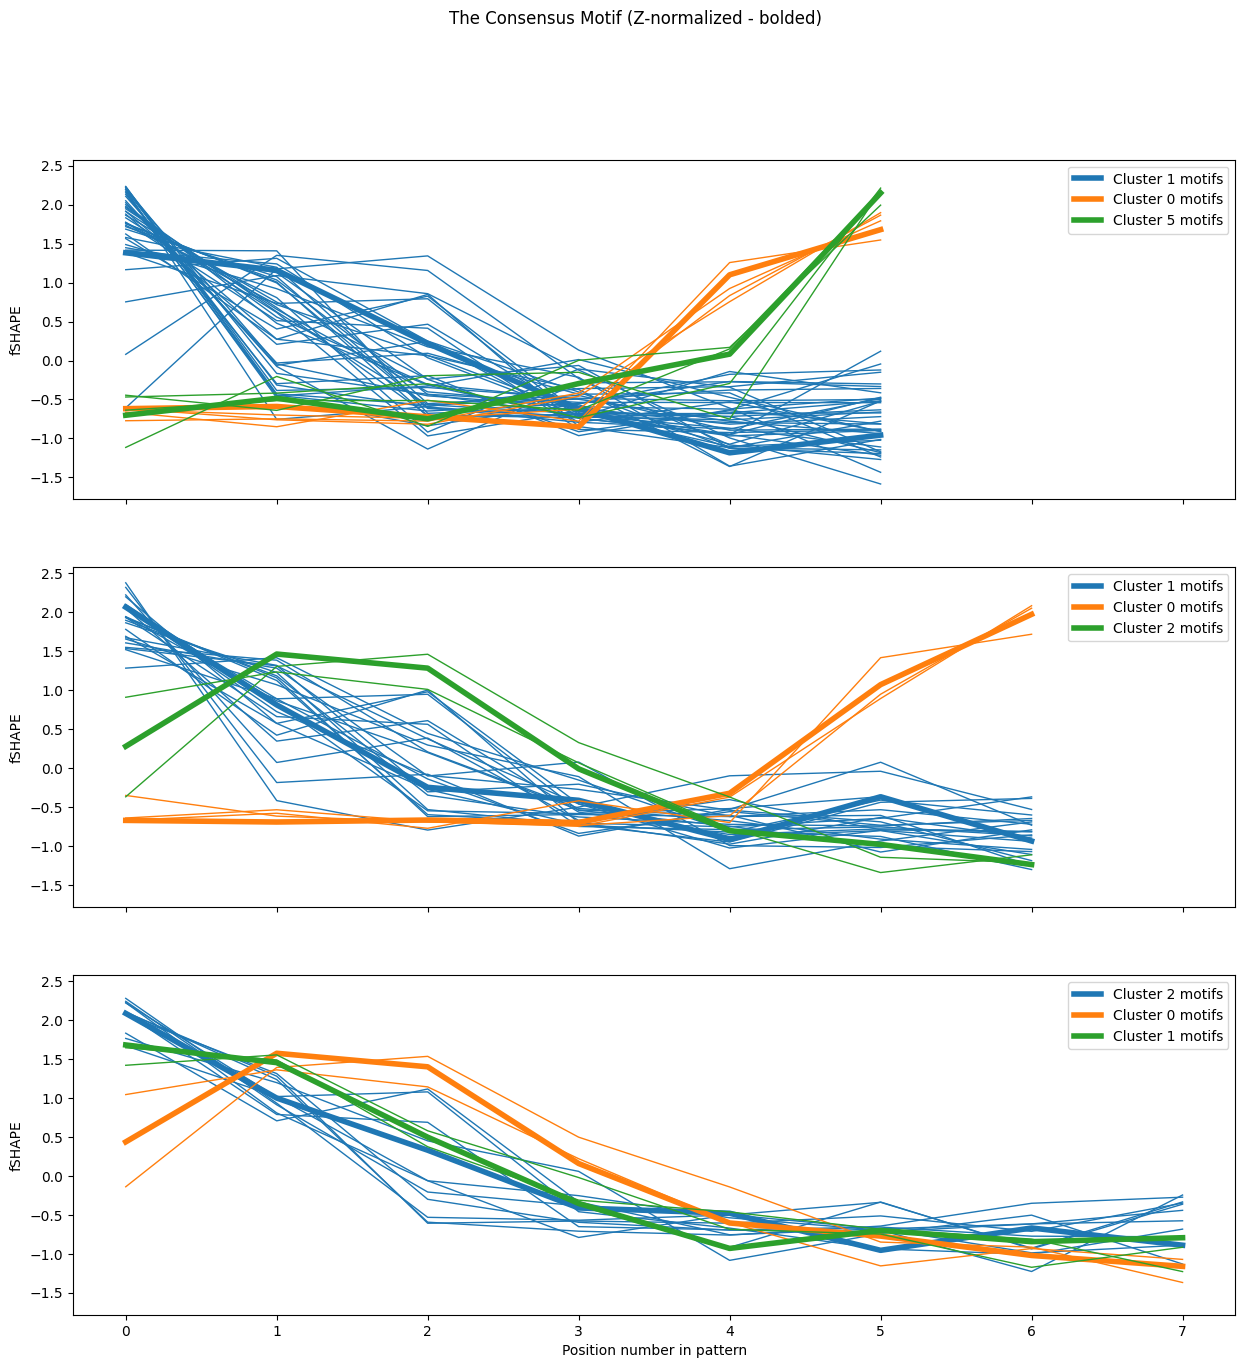

In [66]:
top_clusters_number = 3
consensus_patterns, consensus_fshapes = [expected_pattern], [expected_pattern_df["fSHAPE"].to_numpy()]

fig, axs = plt.subplots(figsize=(15, 15), nrows=3, sharex=True, sharey=True)
colors = sns.color_palette(n_colors=top_clusters_number)

for ax, pattern_length in zip(axs, pattern_lengths):
    curr_patterns, curr_fshapes = np.array(patterns[pattern_length]), np.array(fshapes[pattern_length])
    y_pred = DBSCAN(eps=0.4, min_samples=3).fit_predict(curr_fshapes).astype(int)
    # y_pred = KMeans(n_clusters=3).fit_predict(curr_fshapes).astype(int)
    unique_labels, labels_count = np.unique(y_pred[y_pred != -1], return_counts=True)
    top_labels = unique_labels[np.argsort(-labels_count)][:top_clusters_number]
    
    print(f"Biggest clusters: {top_labels}")
    print(np.sort(labels_count)[-3:])
    for color, label in zip(colors, top_labels):
        cluster_patterns, cluster_fshapes = curr_patterns[y_pred == label], curr_fshapes[y_pred == label]
        _, idx, _ = stumpy.ostinato(cluster_fshapes.tolist(), pattern_length)

        consensus_motif = ''.join(cluster_patterns[idx])
        consensus_patterns.append(consensus_motif)
        consensus_fshapes.append(cluster_fshapes[idx])
        print(f'Consensus motif for cluster {label}: {consensus_motif}')
        plot_motifs(label, cluster_fshapes, idx, ax, color)

    ax.set_ylabel('fSHAPE')
    ax.legend()

fig.suptitle("The Consensus Motif (Z-normalized - bolded)")
plt.xlabel("Position number in pattern")    
# plt.savefig(MOTIFS_PATH)

#### 7. Carry out the transcriptors search. Present results in tabular form.

In [67]:
def ssf(seq1: str, seq2: str) -> float:
    points = 0
    for s1, s2 in zip(seq1, seq2):
        if s1 == s2 or s1 == 'N' or s2 == 'N':
            points += 2
        elif (s1 == 'A' and s2 == 'G') or (s1 == 'G' and s2 == 'A') or (s1 == 'C' and s2 == 'U') or \
                (s1 == 'U' and s2 == 'C') or (s1 == 'C' and s2 == 'T') or (s1 == 'T' and s2 == 'C'):
            points += 1
    return float(points) / len(seq1)

In [68]:
results = defaultdict(list)
for transcript_file in PATTERN_SEARCH_FOLDER.glob("*"):
    transcript_df = pd.read_csv(transcript_file, sep="\t", header=None, names=["fSHAPE", "base", "SHAPE"])
    for pattern, fshape in zip(consensus_patterns, consensus_fshapes):
        pattern_length = len(pattern)
        motifs_num = 0

        for i in range(transcript_df.shape[0] - pattern_length):
            pattern_df = transcript_df.iloc[i:i+pattern_length, :-1]
            if not is_promising(pattern_df["fSHAPE"]):
                continue
            z_norm = stumpy.core.mass(fshape, pattern_df["fSHAPE"])[0]
            if z_norm > 2.5:
                continue
            transcripted_pattern = ''.join(pattern_df["base"])
            ssf_value = None
            if pattern_length == expected_pattern_size:
                ssf_value = ssf(transcripted_pattern, expected_pattern)
            elif pattern_length == expected_pattern_size + 1:
                ssf_value = max(ssf(transcripted_pattern, 'N' + expected_pattern), ssf(transcripted_pattern, expected_pattern + 'N'))
            elif pattern_length == expected_pattern_size + 2:
                ssf_value = ssf(transcripted_pattern, 'N' + expected_pattern + 'N')
            aS_value = 10 * z_norm - ssf_value

            results[pattern].append(dict(nucleotide_sequence=transcripted_pattern, filename=transcript_file.name, start_idx=i+1,
                                         end_idx=i+pattern_length, znEd=z_norm, ssf=ssf_value, aS=aS_value))
            motifs_num += 1
        print(f"Found {motifs_num} motifs in {transcript_file.name}")
        
for motif in results:
    results[motif] = pd.DataFrame(results[motif]).sort_values(by=['aS'])

results[expected_pattern]

Found 113 motifs in hnrnpc_NM_000067_CA2.txt
Found 187 motifs in hnrnpc_NM_000067_CA2.txt
Found 156 motifs in hnrnpc_NM_000067_CA2.txt
Found 136 motifs in hnrnpc_NM_000067_CA2.txt
Found 145 motifs in hnrnpc_NM_000067_CA2.txt
Found 135 motifs in hnrnpc_NM_000067_CA2.txt
Found 145 motifs in hnrnpc_NM_000067_CA2.txt
Found 142 motifs in hnrnpc_NM_000067_CA2.txt
Found 130 motifs in hnrnpc_NM_000067_CA2.txt
Found 144 motifs in hnrnpc_NM_000067_CA2.txt
Found 56 motifs in hnrnpc_NM_000422_KRT17.txt
Found 77 motifs in hnrnpc_NM_000422_KRT17.txt
Found 71 motifs in hnrnpc_NM_000422_KRT17.txt
Found 65 motifs in hnrnpc_NM_000422_KRT17.txt
Found 56 motifs in hnrnpc_NM_000422_KRT17.txt
Found 58 motifs in hnrnpc_NM_000422_KRT17.txt
Found 51 motifs in hnrnpc_NM_000422_KRT17.txt
Found 50 motifs in hnrnpc_NM_000422_KRT17.txt
Found 46 motifs in hnrnpc_NM_000422_KRT17.txt
Found 51 motifs in hnrnpc_NM_000422_KRT17.txt
Found 18 motifs in hnrnpc_NM_000581_GPX1.txt
Found 28 motifs in hnrnpc_NM_000581_GPX1.txt


,nucleotide_sequence,filename,start_idx,end_idx,znEd,ssf,aS
2341,GCCATA,hnrnpc_NM_017527_LY6K.txt,609,614,0.354320,1.333333,2.209865
76,TGATTT,hnrnpc_NM_000067_CA2.txt,1038,1043,0.437997,1.333333,3.046635
1521,GTCCCT,hnrnpc_NM_002116_HLA-A.txt,1158,1163,0.512117,1.500000,3.621166
1514,ACGGAG,hnrnpc_NM_002116_HLA-A.txt,838,843,0.469164,0.833333,3.858306
517,ACTGCG,hnrnpc_NM_001195129_PRSS56.txt,1396,1401,0.550674,1.333333,4.173409
...,...,...,...,...,...,...,...
1911,TGAGGT,hnrnpc_NM_005567_LGALS3BP.txt,446,451,2.485229,0.666667,24.185625
1529,CGGAAC,hnrnpc_NM_002117_HLA-C.txt,372,377,2.485310,0.666667,24.186434
1452,TGAAGT,hnrnpc_NM_001875_CPS1.txt,5194,5199,2.488214,0.666667,24.215472
2262,GAAAAC,hnrnpc_NM_014220_TM4SF1.txt,216,221,2.495775,0.666667,24.291087


#### Save the results into Excel file

In [69]:
with pd.ExcelWriter(DESTINATION_PATH, engine='openpyxl', mode='w') as writer:
    for motif in results:
        results[motif].to_excel(writer, sheet_name=motif, index=False)